In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train = np.load("/kaggle/input/cafa5-dataset/t5_train_embedding.npy")
labels = pd.read_parquet("/kaggle/input/cafa5-dataset/final_train_labels.parquet")

In [3]:
ids = labels["EntryID"]
labels = labels.drop("EntryID", axis = 1)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.1, shuffle= True)

In [5]:
del train
del labels

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [7]:
BATCH_SIZE = 1280
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [8]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2000), dtype=tf.float64, name=None))>

In [9]:
INPUT_SHAPE = [1024]
output_size = 2000

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=output_size,activation='sigmoid')
])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 2000)              1026000   
                                                                 
Total params: 2,080,208
Trainable params: 2,078,160
Non-trainable params: 2,048
__________________________________________

In [11]:
gc.collect()

595

In [12]:
# Compile model
BATCH_SIZE = 2560
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=4,
    validation_data=validation_dataset,
)

Epoch 1/4
101/101 [==============================] - 38s 356ms/step - loss: 0.0944 - binary_accuracy: 0.9745 - auc: 0.7991 - val_loss: 0.4844 - val_binary_accuracy: 0.9844 - val_auc: 0.8842
Epoch 2/4
101/101 [==============================] - 36s 353ms/step - loss: 0.0543 - binary_accuracy: 0.9849 - auc: 0.9039 - val_loss: 0.3500 - val_binary_accuracy: 0.9848 - val_auc: 0.9232
Epoch 3/4
101/101 [==============================] - 35s 350ms/step - loss: 0.0510 - binary_accuracy: 0.9851 - auc: 0.9219 - val_loss: 0.2246 - val_binary_accuracy: 0.9850 - val_auc: 0.9345
Epoch 4/4
101/101 [==============================] - 38s 377ms/step - loss: 0.0492 - binary_accuracy: 0.9853 - auc: 0.9298 - val_loss: 0.1313 - val_binary_accuracy: 0.9851 - val_auc: 0.9398


In [13]:
del train_dataset
del validation_dataset
gc.collect()

4

<Axes: title={'center': 'Accuracy'}>

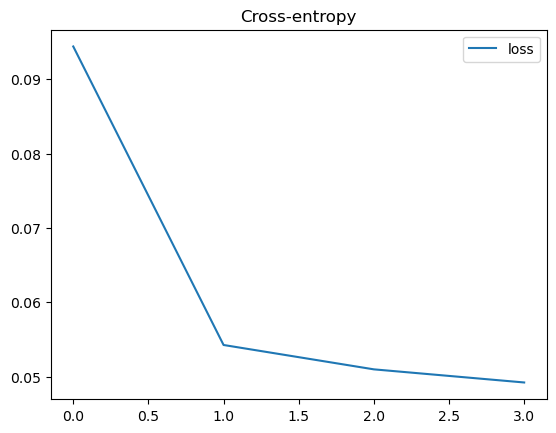

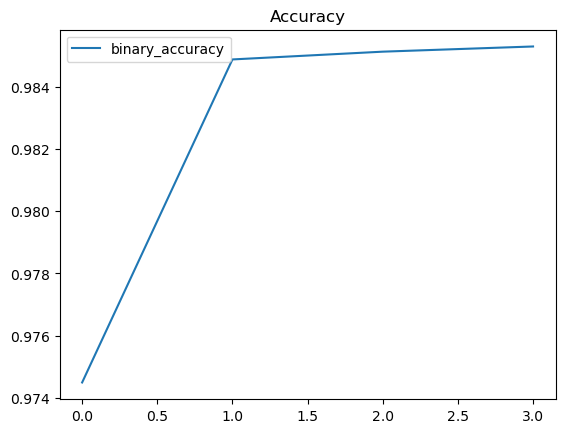

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [15]:
test_df = np.load('/kaggle/input/cafa5-dataset/t5_test_embedding.npy')

# Convert test_embeddings to dataframe
column_num = test_df.shape[1]
test_df = pd.DataFrame(test_df, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [16]:
predictions =  model.predict(test_df)
predictions = predictions.astype(np.float16)

4434/4434 [==============================] - 29s 7ms/step


In [17]:
del X_train
del X_valid
del y_train
del y_valid
del test_df
del model
del ids
gc.collect()

4213

In [18]:
# chunk_size = 5_000
# chunks = [range(i, min(i + chunk_size, len(predictions))) for i in range(0, len(predictions), chunk_size)]

In [19]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
test_ids = np.load("/kaggle/input/cafa5-dataset/test_id.npy")
labels = train_terms['term'].value_counts().index[:2000].tolist()
del train_terms

In [20]:
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/cafa5-dataset/test_id.npy')
l = []
for k in tqdm(list(test_protein_ids), desc = "Creating Submission..."):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

Creating Submission...:   0%|          | 0/141865 [00:00<?, ?it/s]

In [21]:
# final_sub = pd.DataFrame()  # Create an empty DataFrame to hold the final result

# print(f"processing {len(chunks)} chunks of {chunk_size} predictions each")

# for chunk in chunks:
#     print(f"processing chunk {chunk}")
#     sub = pd.DataFrame(data=predictions[chunk], columns=list(labels), index=test_ids[chunk])
#     sub = sub.T.unstack().reset_index(name='prediction')
#     sub = sub.loc[sub['prediction'] > 0]
#     final_sub = pd.concat([final_sub, sub])  # Concatenate current chunk DataFrame to the final DataFrame

# final_sub.head()

In [22]:
# final_sub.shape

In [23]:
# df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
# test_protein_ids = np.load("/kaggle/input/cafa5-helper/test_id.npy")
# l = []
# for k in tqdm(list(test_protein_ids), desc = "Predicting..."):
#     l += [ k] * predictions.shape[1]   

In [24]:
# del test_protein_ids
# gc.collect()

In [25]:
# train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
# labels = train_terms['term'].value_counts().index[:5000].tolist()
# del train_terms